# Warm-starting quantum optimization

## Introduction

Optimization problems with integer variables or constraints are often hard to solve. For example, the Quadratic Unconstrained Binary Optimization (QUBO) problem, i.e.

\begin{align}
\min_{x\in\{0,1\}^n}x^T\Sigma x + \mu^Tx,
\end{align}

is NP-Hard. Here, $\Sigma$ is an $n\times n$ matrix and $x$ is a vector of $n$ binary variables. Note that we could have added the linear term $\mu$ to the diagonal as $x_i^2=x_i$ for $x_i\in\{0, 1\}$. While QUBOs are hard to solve there exists many ways to relax them to problems that are easier to solve.
For example, if $\Sigma$ is semi-definite positive the QUBO can be relaxed and results in a convex Quadratic Program 

\begin{align}
\min_{x\in[0,1]^n}x^T\Sigma x,
\end{align}

which becomes easy to solve as $x$ now represents $n$ continuous variables bound to the range $[0, 1]$.
Such relaxations can be leveraged to warm-start quantum optimization algorithms as shown in [1].

## References

[1] [D. J. Egger, J Marecek, S. Woerner, *Warm-starting quantum optimization*, arXiv:2009.10095](http://arxiv.org/abs/2009.10095)

In [1]:
import copy

import numpy as np

# Problem modelling imports
from docplex.mp.model import Model
from qiskit.primitives import StatevectorSampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

# Qiskit imports
from qiskit_optimization.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.optimizers import COBYLA
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.utils import algorithm_globals

## Preliminaries: relaxing QUBOs

First, we show how to relax a QUBO built with a semi-definite positive matrix to obtain an easy-to-solve QP.

In [2]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective -= 2 * mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    mdl.maximize(objective)
    cost = mdl.sum(x)
    mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

For this example, we use a positive semi-definite matrix $\Sigma$ and a linear term $\mu$ as defined below.

In [3]:
mu = np.array([3.418, 2.0913, 6.2415, 4.4436, 10.892, 3.4051])
sigma = np.array(
    [
        [1.07978412, 0.00768914, 0.11227606, -0.06842969, -0.01016793, -0.00839765],
        [0.00768914, 0.10922887, -0.03043424, -0.0020045, 0.00670929, 0.0147937],
        [0.11227606, -0.03043424, 0.985353, 0.02307313, -0.05249785, 0.00904119],
        [-0.06842969, -0.0020045, 0.02307313, 0.6043817, 0.03740115, -0.00945322],
        [-0.01016793, 0.00670929, -0.05249785, 0.03740115, 0.79839634, 0.07616951],
        [-0.00839765, 0.0147937, 0.00904119, -0.00945322, 0.07616951, 1.08464544],
    ]
)

Using DOCPLEX we build a model with binary variables.

In [4]:
qubo = create_problem(mu, sigma)
print(qubo.prettyprint())

Problem name: docplex_model1

Maximize
  -2.15956824*x0^2 - 0.03075656*x0*x1 - 0.44910424*x0*x2 + 0.27371876*x0*x3
  + 0.04067172*x0*x4 + 0.0335906*x0*x5 - 0.21845774*x1^2 + 0.12173696*x1*x2
  + 0.008018*x1*x3 - 0.02683716*x1*x4 - 0.0591748*x1*x5 - 1.970706*x2^2
  - 0.09229252*x2*x3 + 0.2099914*x2*x4 - 0.03616476*x2*x5 - 1.2087634*x3^2
  - 0.1496046*x3*x4 + 0.03781288*x3*x5 - 1.59679268*x4^2 - 0.30467804*x4*x5
  - 2.16929088*x5^2 + 3.418*x0 + 2.0913*x1 + 6.2415*x2 + 4.4436*x3 + 10.892*x4
  + 3.4051*x5

Subject to
  Linear constraints (1)
    x0 + x1 + x2 + x3 + x4 + x5 == 3  'c0'

  Binary variables (6)
    x0 x1 x2 x3 x4 x5



Such binary problems are hard to deal with but can be solved if the problem instance is small enough. Our example above has as solution

In [5]:
result = CplexOptimizer().solve(qubo)
print(result.prettyprint())

objective function value: 16.7689322
variable values: x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0
status: SUCCESS


We can create a relaxation of this problem in which the variables are no longer binary. Note that we use the `QuadraticProgramToQubo` converter to convert the constraint into a quadratic penalty term. We do this to remain consistent with the steps that the Qiskit optimization module applies internally. 

In [6]:
qp = relax_problem(QuadraticProgramToQubo().convert(qubo))
print(qp.prettyprint())

Problem name: docplex_model1

Minimize
  44.84880018*x0^2 + 85.40922044*x0*x1 + 85.82756812*x0*x2
  + 85.10474511999999*x0*x3 + 85.33779215999999*x0*x4 + 85.34487328*x0*x5
  + 42.90768968*x1^2 + 85.25672692*x1*x2 + 85.37044588*x1*x3 + 85.40530104*x1*x4
  + 85.43763867999999*x1*x5 + 44.65993794*x2^2 + 85.4707564*x2*x3
  + 85.16847247999999*x2*x4 + 85.41462863999999*x2*x5 + 43.89799534*x3^2
  + 85.52806848*x3*x4 + 85.34065100000001*x3*x5 + 44.28602462*x4^2
  + 85.68314192*x4*x5 + 44.85852282*x5^2 - 259.55339164*x0
  - 258.22669163999996*x1 - 262.37689163999994*x2 - 260.57899163999997*x3
  - 267.02739163999996*x4 - 259.54049163999997*x5 + 384.20308746

Subject to
  No constraints

  Continuous variables (6)
    0 <= x0 <= 1
    0 <= x1 <= 1
    0 <= x2 <= 1
    0 <= x3 <= 1
    0 <= x4 <= 1
    0 <= x5 <= 1



The solution of this continuous relaxation is different from the solution to the binary problem but can be used to warm-start a solver when dealing with the binary problem.

In [7]:
sol = CplexOptimizer().solve(qp)
print(sol.prettyprint())

objective function value: -17.012055025682685
variable values: x0=0.1752499576180119, x1=1.480388816398468e-07, x2=0.9709053264087681, x3=0.7384168677494147, x4=0.9999999916475085, x5=0.1443890447016834
status: SUCCESS


In [8]:
c_stars = sol.samples[0].x
print(c_stars)

[0.1752499576180119, 1.480388816398468e-07, 0.9709053264087681, 0.7384168677494147, 0.9999999916475085, 0.1443890447016834]


## QAOA

Here, we illustrate how to warm-start the quantum approximate optimization algorithm (QAOA) by leveraging the relaxed problem shown above. 

### Standard QAOA

First, we use standard QAOA to solve the QUBO. To do this, we convert the QUBO to `QuadraticProgram` class (note that the resulting problem is still a binary problem).

In [9]:
algorithm_globals.random_seed = 12345
qaoa_mes = QAOA(sampler=StatevectorSampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()

In [10]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [11]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 16.768932200000002
variable values: x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0
status: SUCCESS


### Warm-start QAOA

Next, we compare this result to a warm-start QAOA in which we use the solution to the continuous relaxation of the problem. First, we create the initial state 

\begin{align}
|\phi^*\rangle=\bigotimes_{i=0}^{n-1}R_y(\theta_i)|0\rangle_n .
\end{align}

which is given by applying $R_y$ rotations with an angle $\theta=2\arcsin(\sqrt{c^*_i})$ that depends on the solution to the relaxed problem.
Here, $c^*_i$ the value of variable $i$ of the relaxed problem.

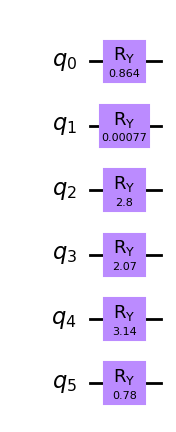

In [12]:
from qiskit import QuantumCircuit

thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl", style="clifford")

Next, we create the mixer operator for QAOA. When warm-starting QAOA we must ensure that the mixer operator has the initial state as ground state. We therefore chose the Hamiltonian

\begin{align}
H_{M,i}^{(ws)}=
\begin{pmatrix}
2c_i^*-1 & -2\sqrt{c_i^*(1-c_i^*)} \\
-2\sqrt{c_i^*(1-c_i^*)} & 1-2c_i^*
\end{pmatrix}
\end{align}

as mixer operator for qubit $i$. Once multiplied by $-i\beta$ and exponentiated this mixer produces the following mixer circuit.

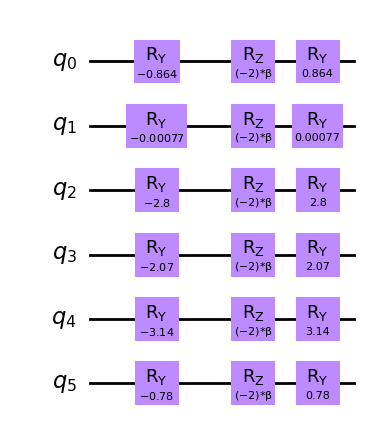

In [13]:
from qiskit.circuit import Parameter

beta = Parameter("β")

ws_mixer = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl", style="clifford")

The initial state and mixer operator can then be passed to QAOA.

In [14]:
ws_qaoa_mes = QAOA(
    sampler=StatevectorSampler(),
    optimizer=COBYLA(),
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)

In [15]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [16]:
ws_qaoa_result = ws_qaoa.solve(qubo)
print(ws_qaoa_result.prettyprint())

objective function value: 16.768932200000002
variable values: x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0
status: SUCCESS


### Analysis

Both results appear to give the same result. However, when we look at the underlying probability distribution we observe that the warm-start QAOA has a much higher probability of sampling the optimal solution.

In [17]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 3:
            qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))

    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]

    return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]


format_qaoa_samples(qaoa_result.samples)

['001110: value: 16.769, probability: 3.7%',
 '001011: value: 14.671, probability: 0.1%',
 '101010: value: 14.626, probability: 1.2%',
 '010110: value: 14.234, probability: 6.7%',
 '100110: value: 13.953, probability: 2.1%',
 '000111: value: 13.349, probability: 2.2%',
 '110010: value: 12.410, probability: 1.1%',
 '010011: value: 12.013, probability: 1.0%',
 '100011: value: 11.559, probability: 0.7%',
 '011100: value: 9.416, probability: 0.1%']

In [18]:
format_qaoa_samples(ws_qaoa_result.samples)

['001110: value: 16.769, probability: 62.5%',
 '001011: value: 14.671, probability: 1.3%',
 '101010: value: 14.626, probability: 0.9%',
 '100110: value: 13.953, probability: 0.1%']

## Warm-start QAOA

The warm-start features above are available in the Qiskit optimization module as a single optimizer named `WarmStartQAOAOptimizer` which is illustrated below. This solver will solve a QUBO with a warm-start QAOA. It computes $c^*$ by relaxing the problem. This behavior is controlled by setting `relax_for_pre_solver` to `True`.

In [19]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [20]:
qaoa_mes = QAOA(sampler=StatevectorSampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0
)

In [21]:
ws_result = ws_qaoa.solve(qubo)
print(ws_result.prettyprint())

objective function value: 16.768932200000002
variable values: x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0
status: SUCCESS


In [22]:
format_qaoa_samples(ws_result.samples)

['001110: value: 16.769, probability: 52.0%',
 '001011: value: 14.671, probability: 2.3%',
 '101010: value: 14.626, probability: 4.4%',
 '100110: value: 13.953, probability: 0.3%',
 '000111: value: 13.349, probability: 0.1%']

In [23]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright